# Preprocessing ratings and textual content for MovieLens datasets

Here, we follow the procedure as that in:

- CDL (KDD'15)  : Collaborative deep learning for recommender systems
- CRAE (NIPS'16): Collaborative Recurrent Autoencoder: Recommend while Learning to Fill in the Blanks
- CVAE (KDD'17) : Collaborative Variational Autoencoder for Recommender Systems

-  (IJCAI'13) : Collaborative topic regression with social regularization for tag recommendation.
-  (TKDE'15) : Relational collaborative topic regression for recommender systems.

which consists in:

- for each user:
  - randomly select P (1 and 10) items for training, and the rest as test
  - repeat the evaluation five times with different training set for each value of P
  - (TODO) use 5-fold cross-validation to find the optimal hyperparameters of CRAE and the baselines

In [1]:
import datetime
import json
import os
import time
import numpy as np

import sys
reload(sys)  
sys.setdefaultencoding('utf8')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from numpy import log10

import pandas as pd
import scipy.sparse

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from operator import itemgetter
from collections import defaultdict
import csv

import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='Serif')
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## First, specify dataset version and input directory

In [2]:
DATASET_ID = 'ml-10m'
DATA_DIR   = '/mnt/hd0/anisio/datasets/ml-1m'
MIN_RATING = 3 # hence, we only consider ratings > 3

P            = 1
execution_id = 1
seed_P_E     = execution_id
output_dir   = 'pro/P_%s_E_%s' % (P, execution_id)

In [3]:
np.random.seed(0)

## Filtering content data

### Here we identify movies:

- with title and plot empty content

In [4]:
columns      = ['id', 'title', 'plot_outline', 'plot', 'keywords', 'language_codes', 'small_cover', 'large_cover']
content_data = pd.read_csv(os.path.join(DATA_DIR, 'IMDb.csv'),
                           sep=',',
                           header=0,
                           usecols=['id', 'title','plot','large_cover'],
                           engine='python')

In [5]:
content_data.shape

(3859, 4)

In [6]:
content_data.head()

,id,title,plot,large_cover
0,1,Toy Story,A little boy named Andy loves to be in his roo...,0/1_large.jpg
1,2,Jumanji,After being trapped in a jungle board game for...,0/2_large.jpg
2,3,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,0/3_large.jpg
3,4,Waiting to Exhale,This story based on the best selling novel by ...,0/4_large.jpg
4,5,Father of the Bride Part II,"In this sequel to ""Father of the Bride"" George...",0/5_large.jpg


In [7]:
# Checking for missing data
content_data.isnull().sum()

id              0
title           1
plot           35
large_cover     0
dtype: int64

There are 1059 movies without title and 1081 movies without plot. We are going to drop them from the dataset

In [8]:
content_data = content_data.dropna(axis=0) # axis = 0 means drop lines

In [9]:
content_data.shape

(3823, 4)

In [10]:
content_data.isnull().sum()

id             0
title          0
plot           0
large_cover    0
dtype: int64

In [11]:
valid_content_movie_ids = pd.unique(content_data['id'])

## Filtering rating data

### We drop instances with:

- movies with empty title and plot description
- ratings smaller than MIN_RATING
- users with less than 10 ratings
- items with less than 10 ratings

In [12]:
columns  = ['user_id', 'item_id', 'rating', 'timestamp']
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), 
                       sep='::',
                       header=0,
                       names=columns,
                       engine='python')

In [13]:
raw_data.head()

,user_id,item_id,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268


In [14]:
raw_data.shape # approx. 1 million ratings

(1000208, 4)

In [15]:
raw_data = raw_data.drop_duplicates(['user_id', 'item_id', 'rating', 'timestamp'])

In [16]:
raw_data.shape # there are not duplicates

(1000208, 4)

In [17]:
# dropping movies with empty content
raw_data = raw_data[raw_data['item_id'].isin(valid_content_movie_ids)]

In [18]:
raw_data.shape

(997220, 4)

In [19]:
# binarize the data (only keep ratings >= MIN_RATING)
raw_data = raw_data[raw_data['rating'] > MIN_RATING]

In [20]:
raw_data['rating'].describe()

count    573106.000000
mean          4.392971
std           0.488411
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [21]:
raw_data.shape

(573106, 4)

In [22]:
raw_data.head(5)

,user_id,item_id,rating,timestamp
2,1,3408,4,978300275
3,1,2355,5,978824291
5,1,1287,5,978302039
6,1,2804,5,978300719
7,1,594,4,978302268


In [23]:
raw_data = raw_data.reindex(np.random.permutation(raw_data.index))

In [24]:
raw_data.head(5)

,user_id,item_id,rating,timestamp
663341,3998,1258,5,965577783
128375,830,522,4,975367535
306816,1831,1704,5,974703110
953039,5755,1288,5,958265305
919244,5555,590,4,959458885


In [25]:
print raw_data[raw_data.index==663341]

In [26]:
def get_count(data, column):
    rating_count_group_by_column = data[[column]].groupby(column, as_index=False)
    count                        = rating_count_group_by_column.size()
    return count

In [27]:
def filter_triplets(data, min_items_per_user=12, min_ratings_per_item=10):
    # only keep triplets for items rated by at least min_ratings_per_item
    if min_ratings_per_item > 0:
        item_count = get_count(data, 'item_id')
        data       = data[data['item_id'].isin(item_count.index[item_count >= min_ratings_per_item])]
    # only keep triplets for users who rated at least min_items_per_user
    # after filtering, a small proportion of the items may have less than min_ratings_per_item
    # TODO: verify this later
    if min_items_per_user > 0:
        user_count = get_count(data, 'user_id')
        data       = data[data['user_id'].isin(user_count.index[user_count >= min_items_per_user])]       
    # update both user_count and item_count after filtering
    user_count, item_count = get_count(data, 'user_id'), get_count(data, 'item_id')
    return data, user_count, item_count

In [28]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [29]:
raw_data.head()

,user_id,item_id,rating,timestamp
663341,3998,1258,5,965577783
128375,830,522,4,975367535
306816,1831,1704,5,974703110
953039,5755,1288,5,958265305
919244,5555,590,4,959458885


In [30]:
raw_data.shape

(568537, 4)

In [31]:
user_activity.head()

user_id
1    44
2    73
3    37
4    18
5    81
dtype: int64

In [32]:
item_popularity.head()

item_id
1    1651
2     283
3     147
4      37
5      96
dtype: int64

For each value of P (1 and 10), we build different training, validation and testing sets

In [33]:
df = raw_data.copy()

In [34]:
grouped = df.groupby('user_id', as_index=False)['item_id'].agg({'list':(lambda x: list(x))})

In [35]:
grouped.head(5)

,user_id,list
0,1,"[1566, 1, 1029, 1961, 3105, 919, 1721, 2762, 2..."
1,2,"[1370, 3147, 2396, 1293, 2858, 3418, 1124, 195..."
2,3,"[1136, 1961, 1968, 1291, 3421, 3671, 653, 1198..."
3,4,"[480, 1097, 1201, 1214, 2366, 3418, 3468, 1387..."
4,5,"[1897, 2599, 562, 2908, 1449, 2890, 1513, 515,..."


## Let's plot the distribution of rated items

In [36]:
grouped['rating_frequency'] = [len(grouped[grouped.index==i]['list'].values[0]) for i in range(grouped.shape[0])]

(array([  1.21000000e+03,   8.43000000e+02,   6.20000000e+02,
          4.60000000e+02,   3.95000000e+02,   3.27000000e+02,
          2.82000000e+02,   2.02000000e+02,   2.15000000e+02,
          1.59000000e+02,   1.52000000e+02,   1.12000000e+02,
          9.90000000e+01,   8.70000000e+01,   7.20000000e+01,
          8.30000000e+01,   7.50000000e+01,   6.70000000e+01,
          3.50000000e+01,   4.10000000e+01,   3.60000000e+01,
          3.20000000e+01,   3.30000000e+01,   2.10000000e+01,
          2.40000000e+01,   1.50000000e+01,   1.20000000e+01,
          2.40000000e+01,   1.40000000e+01,   1.00000000e+01,
          8.00000000e+00,   1.70000000e+01,   1.10000000e+01,
          9.00000000e+00,   7.00000000e+00,   6.00000000e+00,
          8.00000000e+00,   5.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
        

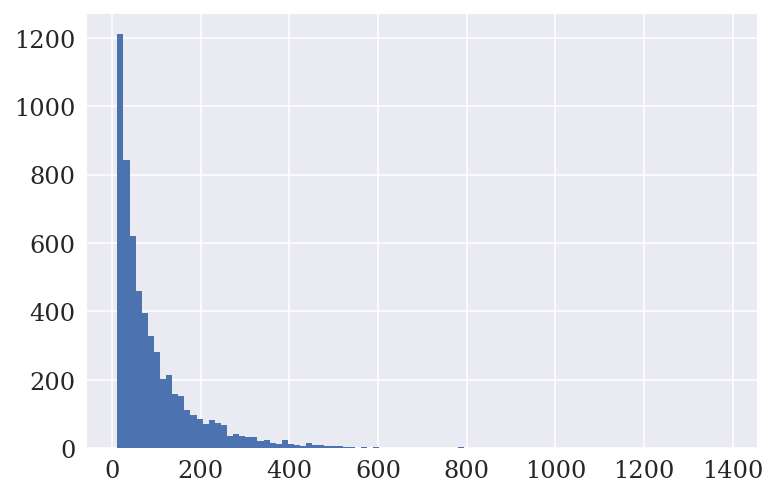

In [37]:
plt.hist(grouped['rating_frequency'],bins=100)
plt.show()

In [38]:
grouped['rating_frequency'].describe()

count    5867.000000
mean       96.904210
std       104.031504
min        12.000000
25%        29.000000
50%        60.000000
75%       125.000000
max      1385.000000
Name: rating_frequency, dtype: float64

In [39]:
num_users_min_ratings = len(grouped[grouped['rating_frequency']==10])
print 'Num users with 10 ratings: %s (%.3f%%)' % (num_users_min_ratings, 100*(float(num_users_min_ratings)/grouped.shape[0]))

In [40]:
grouped=grouped.drop('rating_frequency', axis=1)

## Let's build train/valid/test files

In [41]:
def split_train_val_test(x, train_size, seed):
    np.random.seed(seed)
    train       = np.random.choice(x, [1,train_size], replace=False)[0]
    holdout     = np.array(list(set(x).difference(set(train))))
    num_ratings = len(holdout)
    if num_ratings > 0:
        validation = np.random.choice(num_ratings, size=int(np.ceil(0.10*num_ratings)),replace=False)
        validation_idx = np.zeros(num_ratings, dtype=bool)
        validation_idx[validation] = True
        validation = holdout[validation_idx]
        test = holdout[~validation_idx]
    else:
        validation = np.array([])
        test = np.array([])
    return[train, validation, test]

In [42]:
def get_data(line, pos):
    return line[pos]

In [43]:
def get_split_data_frame(raw_data, grouped_data, label):
    d    = {'train':0, 'val':1, 'test':2}
    fold = grouped_data['splits'].apply(get_data, pos=d[label])
    
    items = fold.values
    users = grouped_data['user_id'].values
    
    tmp_list  = map(lambda pair: zip([pair[0]]*len(pair[1]),pair[1]), zip(users, items))
    flat_list = [item for sublist in tmp_list for item in sublist]
    tmp_df    = pd.DataFrame(flat_list,columns=['user_id','item_id'])
    return pd.merge(raw_data, tmp_df)

In [44]:
grouped['splits'] = grouped['list'].apply(split_train_val_test, train_size=P, seed=seed_P_E)

In [45]:
grouped.head()

,user_id,list,splits
0,1,"[1566, 1, 1029, 1961, 3105, 919, 1721, 2762, 2...","[[1961], [1028, 260, 588, 2018, 1270], [1, 102..."
1,2,"[1370, 3147, 2396, 1293, 2858, 3418, 1124, 195...","[[1188], [265, 1225, 1198, 3255, 1357, 1873, 1..."
2,3,"[1136, 1961, 1968, 1291, 3421, 3671, 653, 1198...","[[1968], [1049, 2858, 480, 2115], [260, 1266, ..."
3,4,"[480, 1097, 1201, 1214, 2366, 3418, 3468, 1387...","[[3468], [2692, 1198], [480, 1954, 2947, 2951,..."
4,5,"[1897, 2599, 562, 2908, 1449, 2890, 1513, 515,...","[[2029], [994, 2890, 2571, 2770, 866, 1513, 41..."


In [46]:
train_raw_data = get_split_data_frame(raw_data, grouped, 'train')
val_raw_data   = get_split_data_frame(raw_data, grouped, 'val')
test_raw_data  = get_split_data_frame(raw_data, grouped, 'test')

In [47]:
train_raw_data.head()

,user_id,item_id,rating,timestamp
0,4339,1831,4,965232951
1,3662,1301,5,966429140
2,4420,293,4,965122428
3,4448,1449,5,1001419438
4,2909,266,4,1009393114


In [48]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_data.shape[0]) # the whole
# is the sum of partitions

In [49]:
## Sanity toy test of above code

#tmp=grouped.head(5)
#tmp=tmp.drop('splits',axis=1)
#def get_five(x):
#    return x[:5]
#tmp['list'] = tmp['list'].apply(get_five)
#tmp['splits'] = tmp['list'].apply(split_train_val_test, train_size=P)
#get_split_data_frame(raw_data, tmp, 'train')
#get_split_data_frame(raw_data, tmp, 'val')
#get_split_data_frame(raw_data, tmp, 'test')

In [50]:
#TODO: check https://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions

def get_plot_distribution(c, xlabel):

    dict_items=dict(c)
    bla = dict(Counter(dict_items.values()))

    plt.xscale('log')
    plt.yscale('log')

    plt.scatter(bla.keys(),bla.values(),c='b',marker='x')

    #plt.xlim((1e-4,1e-1))
    #plt.ylim((.8,1.1e2))
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

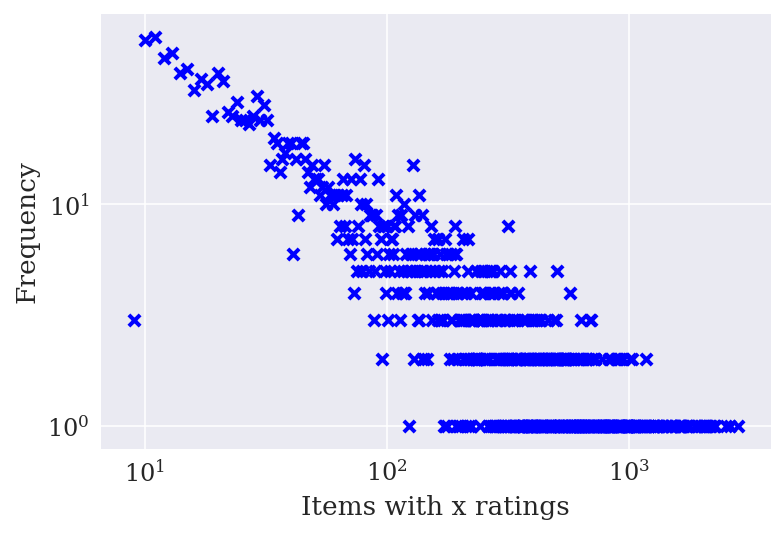

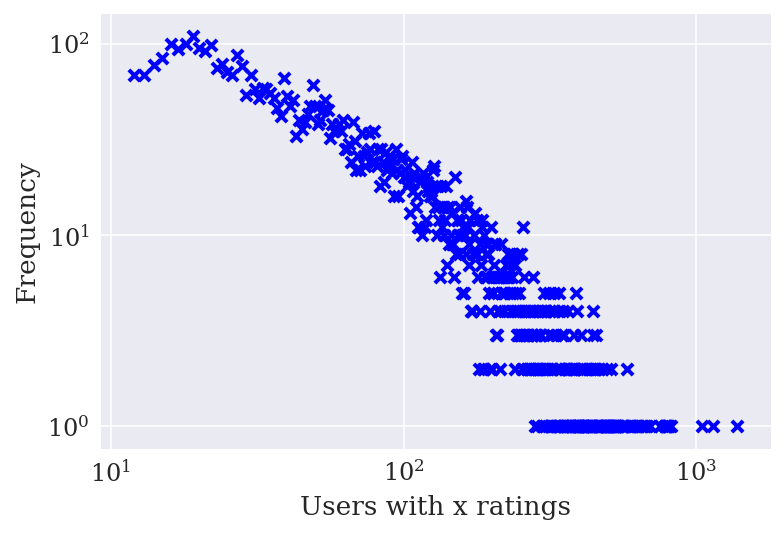

In [51]:
get_plot_distribution(item_popularity, 'Items with x ratings')
get_plot_distribution(user_activity, 'Users with x ratings')

#### Filtering users from validation set

In [52]:
print('There are unique users: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['user_id'])), len(pd.unique(val_raw_data['user_id'])), len(pd.unique(test_raw_data['user_id']))))

#### Filtering items from validation set

In [53]:
print('There are unique items: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['item_id'])), len(pd.unique(val_raw_data['item_id'])), len(pd.unique(test_raw_data['item_id']))))

### Here, we guarantee that there is no item that appears only in valiation and testing

In [54]:
train_items = train_raw_data['item_id'].values

In [55]:
val_raw_data = val_raw_data[val_raw_data['item_id'].isin(train_items)]

In [56]:
test_raw_data = test_raw_data[test_raw_data['item_id'].isin(train_items)]

In [57]:
print('There are unique items: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['item_id'])), len(pd.unique(val_raw_data['item_id'])), len(pd.unique(test_raw_data['item_id']))))

In [58]:
raw_processed_data = pd.concat([train_raw_data, val_raw_data, test_raw_data])

In [59]:
raw_processed_data.shape

(500607, 4)

In [60]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_processed_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_processed_data.shape[0]) # the whole
# is the sum of partitions

In [61]:
print 'Num users in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (len(pd.unique(raw_processed_data['user_id'])),
                                                               len(pd.unique(train_raw_data['user_id'])),
                                                               len(pd.unique(val_raw_data['user_id'])),
                                                               len(pd.unique(test_raw_data['user_id'])))

In [62]:
print 'Num items in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (len(pd.unique(raw_processed_data['item_id'])),
                                                               len(pd.unique(train_raw_data['item_id'])),
                                                               len(pd.unique(val_raw_data['item_id'])),
                                                               len(pd.unique(test_raw_data['item_id'])))

In [63]:
print 'Num ratings in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (raw_processed_data.shape[0],
                                                                      train_raw_data.shape[0],
                                                                      val_raw_data.shape[0],
                                                                      test_raw_data.shape[0])

### Storing user and item ids

In [64]:
raw_processed_data, user_activity, item_popularity = filter_triplets(raw_processed_data, min_items_per_user=0, min_ratings_per_item=0)

In [65]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_processed_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_processed_data.shape[0]) # the whole
# is the sum of partitions

In [66]:
print output_dir

In [67]:
unique_user_id = user_activity.index
unique_item_id = item_popularity.index

user2id = dict((user_id, i) for (i, user_id) in enumerate(unique_user_id))
item2id = dict((item_id, i) for (i, item_id) in enumerate(unique_item_id))

os.system('mkdir -p %s' % (os.path.join(DATA_DIR, output_dir)))
with open(os.path.join(DATA_DIR, output_dir, 'unique_user_id.dat'), 'w') as f:
    for user_id in unique_user_id:
        f.write('%s\n' % user_id)

with open(os.path.join(DATA_DIR, output_dir, 'unique_item_id.dat'), 'w') as f:
    for item_id in unique_item_id:
        f.write('%s\n' % item_id)

0

### Dump processed data as user_id,item_id,timestamp format

In [68]:
def dump(data):
    user_id = map(lambda x: user2id[x], data['user_id'])
    item_id = map(lambda x: item2id[x], data['item_id'])
    data['user_id'] = user_id
    data['item_id'] = item_id
    return data[['user_id', 'item_id', 'timestamp']]

In [69]:
train_data = dump(train_raw_data.copy())
train_data.to_csv(os.path.join(DATA_DIR, output_dir, 'train.dat'), index=False)

validation_data = dump(val_raw_data.copy())
validation_data.to_csv(os.path.join(DATA_DIR, output_dir, 'validation.dat'), index=False)

test_data = dump(test_raw_data.copy())
test_data.to_csv(os.path.join(DATA_DIR, output_dir, 'test.dat'), index=False)

## Representation of textual content (tfidf and tf: from title+plot)

### We consider the following criteria:

- concatenate title and plot
- remove stopwords
- use tf-idf to choose top 8k words as vocabulary

In [70]:
content_data.shape

(3823, 4)

In [71]:
content_data = content_data[content_data['id'].isin(pd.unique(train_raw_data['item_id']))]

In [72]:
content_data.shape

(1521, 4)

In [73]:
content_data.head()

,id,title,plot,large_cover
0,1,Toy Story,A little boy named Andy loves to be in his roo...,0/1_large.jpg
1,2,Jumanji,After being trapped in a jungle board game for...,0/2_large.jpg
2,3,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,0/3_large.jpg
5,6,Heat,Hunters and their prey--Neil and his professio...,0/6_large.jpg
6,7,Sabrina,While she was growing up Sabrina Fairchild spe...,0/7_large.jpg


### reference for below functions: https://buhrmann.github.io/tfidf-analysis.html

In [74]:
def top_tfidf_feats(tfv, row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids   = np.argsort(row)[::-1][:top_n]
    top_feats  = [(features[i], row[i], tfv.idf_[i]) for i in topn_ids]
    df         = pd.DataFrame(top_feats)
    df.columns = ['word', 'tfidf', 'idf']
    return df[df['tfidf']>0]

In [75]:
def top_feats_in_doc(tfv, Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(tfv, row, features, top_n)

In [76]:
# Getting top VOCABULARY_SIZE words from plot according to tfidf
output_vocabulary_file = os.path.join(DATA_DIR, '%s/vocabulary_%s.csv' % (output_dir, DATASET_ID))
force = False # force vocabulary construction, this may take a while

vocab = list()
if force or not os.path.exists(output_vocabulary_file):

    VOCABULARY_SIZE = 8000

    tfv = TfidfVectorizer(strip_accents='unicode',
                          analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                          decode_error='replace', encoding='utf-8')
    
    description   = content_data['title'].astype(str).str.cat(content_data['plot'].astype(str), sep=' ')
    tfidf_matrix  = tfv.fit_transform(description.values.astype('U'))
    feature_names = tfv.get_feature_names()
    
    result = pd.DataFrame()
    for i in range(len(description)):
        tmp = top_feats_in_doc(tfv, tfidf_matrix, feature_names,i)
        result = pd.concat([tmp, result])
        
    result = result.groupby('word', sort=False, as_index=True).max().reset_index().sort_values(['tfidf'], ascending=False)[:VOCABULARY_SIZE]

    result.to_csv(output_vocabulary_file, index=False)
    vocab = list(result['word'].values.astype(str))
    
else: # read vocabulary file
    print 'reading %s' % (output_vocabulary_file)
    with open(output_vocabulary_file, 'r') as infile:
        reader = csv.reader(infile)
        reader.next() # ignoring header
        for rows in reader:
            vocab.append(rows[0])
        
print 'Vocabulary size %s' % (len(vocab))

In [77]:
def rep_dict(doc, vectorizer, feat_names):
    tmp_doc_vec = vectorizer.transform([doc])
    result = {'%s'.encode('utf-8') % (feat_names[col]):float('%.5f' % (tmp_doc_vec[0,col])) 
              for col in tmp_doc_vec[0,:].nonzero()[1]}
    return result

In [78]:
# Getting tfidf representation of items
tfv = TfidfVectorizer(strip_accents='unicode',
                      analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                      decode_error='replace', encoding='utf-8',
                      vocabulary=vocab)
description   = content_data['title'].astype(str).str.cat(content_data['plot'].astype(str), sep=' ')
tfidf_matrix  = tfv.fit_transform(description.values.astype('U'))
feature_names = tfv.get_feature_names()
content_data['tfidf_title_plot']  = description.apply(lambda x : rep_dict(x, tfv, feature_names))

In [79]:
content_data.head()

,id,title,plot,large_cover,tfidf_title_plot
0,1,Toy Story,A little boy named Andy loves to be in his roo...,0/1_large.jpg,"{u'separated': 0.02565, u'named': 0.05449, u'f..."
1,2,Jumanji,After being trapped in a jungle board game for...,0/2_large.jpg,"{u'magical': 0.10177, u'old': 0.0237, u'help':..."
2,3,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,0/3_large.jpg,"{u'shop': 0.19317, u'married': 0.06909, u'old'..."
5,6,Heat,Hunters and their prey--Neil and his professio...,0/6_large.jpg,"{u'detective': 0.07956, u'major': 0.07907, u'3..."
6,7,Sabrina,While she was growing up Sabrina Fairchild spe...,0/7_large.jpg,"{u'dollar': 0.02977, u'soon': 0.01324, u'years..."


In [80]:
# Getting tf representation of items
cfv = CountVectorizer(strip_accents='unicode',
                      analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                      decode_error='replace', encoding='utf-8',
                      vocabulary=vocab)
description = content_data['title'].astype(str).str.cat(content_data['plot'].astype(str), sep=' ')
tf_matrix  = tfv.fit_transform(description.values.astype('U'))
feature_names = tfv.get_feature_names()
content_data['tf_title_plot']  = description.apply(lambda x : rep_dict(x, cfv, feature_names))

In [81]:
content_data.head()

,id,title,plot,large_cover,tfidf_title_plot,tf_title_plot
0,1,Toy Story,A little boy named Andy loves to be in his roo...,0/1_large.jpg,"{u'separated': 0.02565, u'named': 0.05449, u'f...","{u'reunite': 1.0, u'real': 1.0, u'cadet': 1.0,..."
1,2,Jumanji,After being trapped in a jungle board game for...,0/2_large.jpg,"{u'magical': 0.10177, u'old': 0.0237, u'help':...","{u'old': 1.0, u'help': 1.0, u'suddenly': 1.0, ..."
2,3,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,0/3_large.jpg,"{u'shop': 0.19317, u'married': 0.06909, u'old'...","{u'shop': 2.0, u'months': 1.0, u'bait': 2.0, u..."
5,6,Heat,Hunters and their prey--Neil and his professio...,0/6_large.jpg,"{u'detective': 0.07956, u'major': 0.07907, u'3...","{u'detective': 2.0, u'major': 2.0, u'30': 1.0,..."
6,7,Sabrina,While she was growing up Sabrina Fairchild spe...,0/7_large.jpg,"{u'dollar': 0.02977, u'soon': 0.01324, u'years...","{u'dollar': 1.0, u'soon': 1.0, u'years': 3.0, ..."


In [82]:
# dump textual representations
content_data.to_csv(os.path.join(DATA_DIR, output_dir, 'tf_title_plot.csv'), 
                    columns=['id', 'tf_title_plot'], index=False)
content_data.to_csv(os.path.join(DATA_DIR, output_dir, 'tfidf_title_plot.csv'), 
                    columns=['id', 'tfidf_title_plot'], index=False)

## Checking if there is content for all items in train, validation, and test sets

In [83]:
a = set(valid_content_movie_ids)
b = set(pd.unique(train_raw_data['item_id']))
c = set(pd.unique(val_raw_data['item_id']))
d = set(pd.unique(test_raw_data['item_id']))

In [84]:
print len(b.difference(a))
print len(c.difference(a))
print len(d.difference(a))

Ok, we have all descriptions that we need!

## After filtering, we have a dataset with these numbers:

In [85]:
num_users   = len(pd.unique(raw_processed_data['user_id']))
num_items   = len(pd.unique(raw_processed_data['item_id']))
num_ratings = raw_processed_data['rating'].shape[0]
sparsity    = 1. * raw_processed_data.shape[0] / (num_users * num_items)
print '#users %s #items %s #ratings %s (sparsity: %.3f)' % (num_users, num_items, num_ratings, sparsity)

In [87]:
(num_users, num_items, num_ratings, sparsity)

(5867, 1521, 500607, 0.05609854738619276)